In [129]:
import pandas as pd
import datetime
import numpy as np


from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from tqdm import tqdm #A tqdm progress bar shows you how much time has elapsed and the estimated time remaining for the iterable
import sklearn.metrics as skmetrics #For evaluation metrics
import seaborn as sns

import warnings                               
warnings.filterwarnings('ignore')

Thaughts:
 - Holidays dont make sense to add
 - Seasonality is hard in general with this data

In [130]:
df = pd.read_csv('../train.csv')
df['Datetime'] = pd.to_datetime(df['Datetime']).dt.date
df = df.groupby(df['Datetime']).mean()
df[:10]

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
Datetime,,,,,,,,,,,,,,,,,,,
2018-01-01,366.223561,25.528849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,276.727612,74.042120,NaN,NaN,276.727612,5.263797
2018-01-02,462.550740,25.357526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274.105603,93.555723,NaN,NaN,274.105603,5.390719
2018-01-03,454.417752,24.379363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,286.369130,91.627843,NaN,NaN,286.369130,5.295225
2018-01-04,369.952190,24.912347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,284.445471,74.360621,NaN,NaN,284.445471,5.094994
2018-01-05,319.446595,23.535679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,292.013293,64.366148,NaN,NaN,292.013293,4.915224
2018-01-06,337.470688,21.278356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,333.250000,68.641368,NaN,NaN,333.250000,5.464902
2018-01-08,861.267127,23.737759,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,280.557391,174.472688,NaN,NaN,280.557391,6.886447
2018-01-09,514.967905,23.565185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,278.533693,104.224432,NaN,NaN,278.533693,5.679249
2018-01-10,485.426583,24.865492,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,287.782474,98.305148,NaN,NaN,287.782474,5.643023


In [131]:
df.shape, df.isna().sum()

((734, 19),
 ActivePower                       0
 AmbientTemperatue                 4
 BearingShaftTemperature         273
 Blade1PitchAngle                428
 Blade2PitchAngle                428
 Blade3PitchAngle                428
 GearboxBearingTemperature       273
 GearboxOilTemperature           273
 GeneratorRPM                    273
 GeneratorWinding1Temperature    273
 GeneratorWinding2Temperature    273
 HubTemperature                  273
 MainBoxTemperature              273
 NacellePosition                   3
 ReactivePower                     0
 RotorRPM                        273
 TurbineStatus                   269
 WindDirection                     3
 WindSpeed                         1
 dtype: int64)

Lots of nas lets mean impute.

In [132]:
column_means = df.mean()
df = df.fillna(column_means)
df.isna().sum()

ActivePower                     0
AmbientTemperatue               0
BearingShaftTemperature         0
Blade1PitchAngle                0
Blade2PitchAngle                0
Blade3PitchAngle                0
GearboxBearingTemperature       0
GearboxOilTemperature           0
GeneratorRPM                    0
GeneratorWinding1Temperature    0
GeneratorWinding2Temperature    0
HubTemperature                  0
MainBoxTemperature              0
NacellePosition                 0
ReactivePower                   0
RotorRPM                        0
TurbineStatus                   0
WindDirection                   0
WindSpeed                       0
dtype: int64

Find variables with strong correlation to engineer some extranuous features for the model.

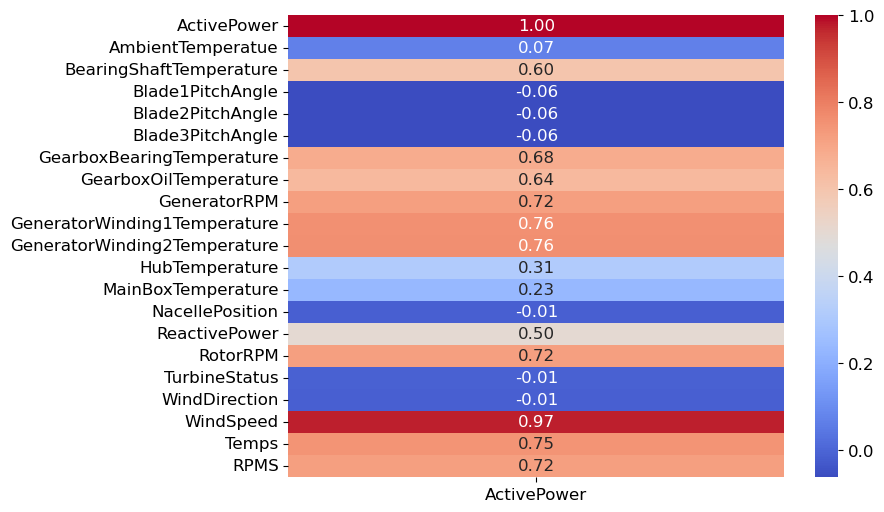

In [133]:
df['Temps'] = (df['GeneratorWinding2Temperature'] + df['GeneratorWinding2Temperature'] + df['GearboxBearingTemperature'] + df['GearboxOilTemperature'])
df['RPMS'] = (df['GeneratorRPM'] + df['RotorRPM'])
corr = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr[['ActivePower']], annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

THis feature looks great, strong linear correlation.

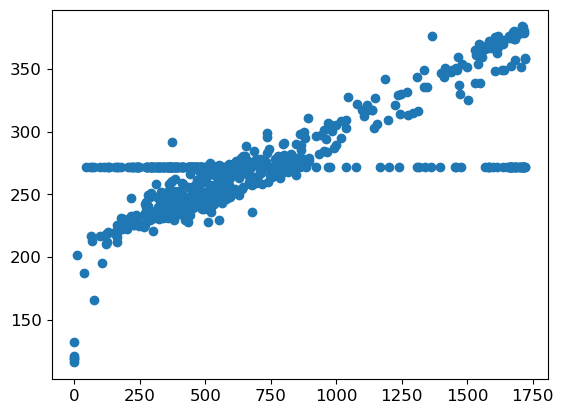

In [134]:
plt.scatter(df['ActivePower'], df['Temps']) #  horizontal line shows the mean impupted values

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


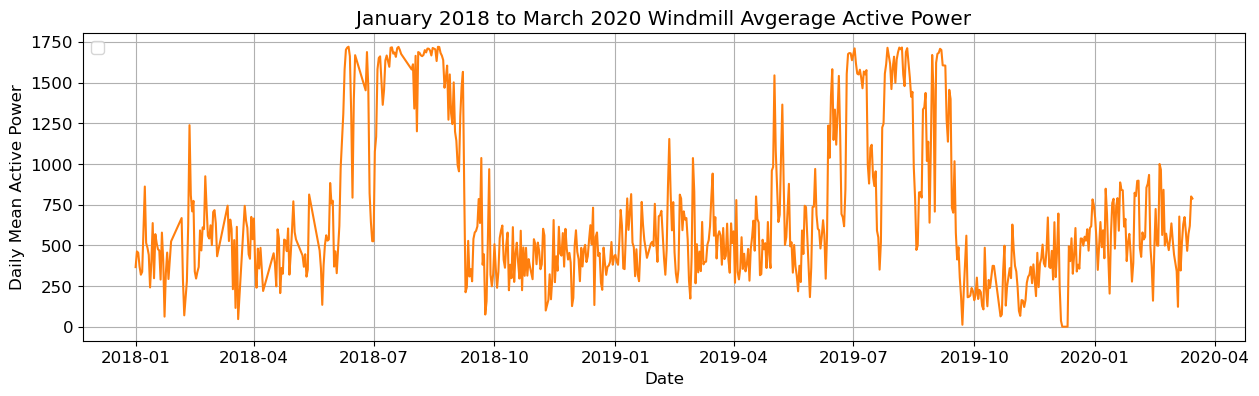

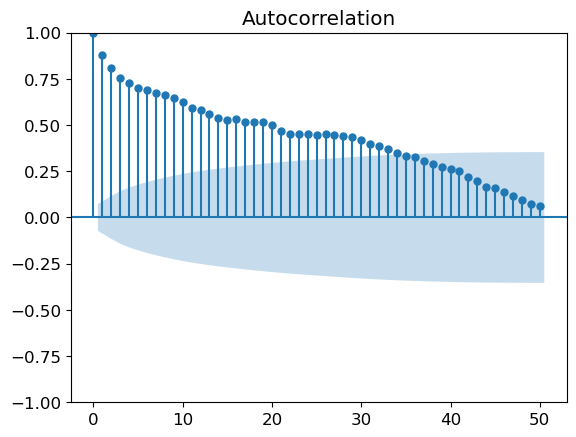

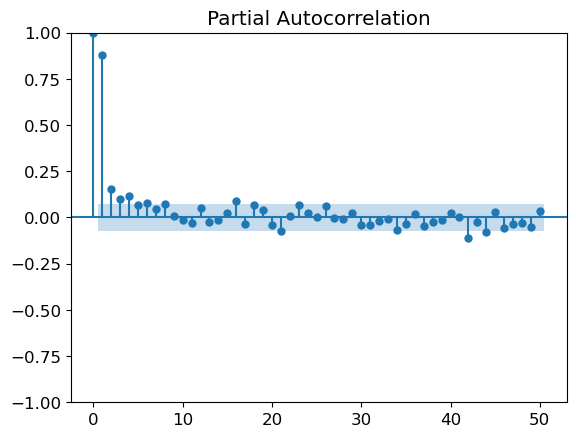


adf test p-value: 0.01792376595212781 ==> stationary


In [135]:
#time series plot
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(15, 4))

ax.plot(df['ActivePower'], color='tab:orange')#, label='Daily Confirmed Case')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Mean Active Power')
ax.set_title('January 2018 to March 2020 Windmill Avgerage Active Power')
ax.grid(True)
ax.legend(loc='upper left')
plt.show()
# ACF
plot_acf(df['ActivePower'],lags=50)
plt.show()
# PACF
plot_pacf(df['ActivePower'],lags=50)
plt.show()
# Dickey Fuller Test
adf_result = adfuller(df['ActivePower'], autolag="AIC")[1]
if adf_result <= 0.05:
    print(f'\nadf test p-value: {adf_result} ==> stationary')
else:
    print(f'\nadf test p-value: {adf_result} ==> non-stationary')

## SARIMAX model Attempt

In [136]:
def evaluate_models_cv_exog(dataset, exog, p_values, d_values, q_values, P_values, D_values, Q_values, m, k):
    K=k
    result = []
    best_rmse, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            trend_order = (p,d,q)
                            seasonal_order = (P,D,Q,m)
                            cfg = [(p,d,q), (P,D,Q,m)]
                            validation_size=31
                            train_size=len(dataset)-validation_size*K
                            rmse=0
                            for k in range(K):
                                train, test = dataset[0:train_size+k*validation_size], dataset[train_size+k*validation_size:train_size+(k+1)*validation_size]
                                train_x, test_x = exog[0:train_size+k*validation_size], exog[train_size+k*validation_size:train_size+(k+1)*validation_size]
                                model = ARIMA(train, exog=train_x, order=trend_order, seasonal_order=seasonal_order)
                                model_fit = model.fit()
                                predictions=model_fit.predict(start=train_size+k*validation_size, end=train_size+(k+1)*validation_size-1, exog=test_x)
                                # y_bar = test.mean(numeric_only=True)
                                rmse += np.sum(mean_squared_error(np.array(predictions), test)) / test.shape[0]
                            rmse_avg=rmse/K
                            result.append((cfg, rmse_avg))
                            if rmse_avg < best_rmse:
                                best_rmse, best_cfg = rmse_avg, cfg
                                print('SARIMAX%s RMSE=%.3f' % (cfg,rmse_avg))
    print('Best SARIMAX%s RMSE=%.3f' % (best_cfg, best_rmse))

    return (best_rmse), (best_cfg)

SARIMAX Takes way to long to grid search... Lets try other models.

In [152]:
p = [4]
d = [0]
q = [3]
P = [6]
D = [0]
Q = [5]
m = 12
k = 2

#best = evaluate_models_cv_exog(df['ActivePower'], df[['GeneratorRPM', 'WindSpeed', 'Temps']], p, d, q, P, D, Q, m, k) # (0*3)(5,0,3,12) # 711.55

SARIMAX Results Forecasting 30 Days @ (0,0,0), (5,0,3):
- ['Temps'], RMSE: 
- ['GeneratorRPM', 'WindSpeed'], RMSE: 71.654
- ['Temps', 'RotorRPM'], RMSE: 
- ['Temps', 'WindSpeed', 'GeneratorRPM'], RMSE: 69.47
- ['WindSpeed', 'RotorRPM'], RMSE: 

SARIMAX Results Forecasting 30 Days @ (4,0,3), (5,0,3):
- ['Temps'], RMSE: 
- ['GeneratorRPM', 'WindSpeed'],
- ['Temps', 'RotorRPM'], RMSE: 
- ['Temps', 'WindSpeed', 'GeneratorRPM'], RMSE: 67.36
- ['WindSpeed', 'RotorRPM'], RMSE: 

SARIMAX Results Forecasting 30 Days @ (6,0,3), (6,0,3,12):
- ['Temps'], RMSE: 
- ['GeneratorRPM', 'WindSpeed'],
- ['Temps', 'RotorRPM'], RMSE: 
- ['Temps', 'WindSpeed', 'GeneratorRPM'], RMSE: -
- ['WindSpeed', 'RotorRPM'], RMSE: 
Looks good!

In [153]:
k = 31 #  Forecast length 
exog = ['Temps', 'WindSpeed', 'RotorRPM', 'RPMS'] # Exogenous Variables to Include

# variables to be used in training
y = df['ActivePower'][:-k]
X = df[exog][:-k]

testX, testY = df[exog][-k:], df['ActivePower'][-k:]

In [154]:
X.join(y)

,Temps,WindSpeed,RotorRPM,RPMS,ActivePower
Datetime,,,,,
2018-01-01,272.260329,5.263797,11.269820,1267.425033,366.223561
2018-01-02,272.260329,5.390719,11.269820,1267.425033,462.550740
2018-01-03,272.260329,5.295225,11.269820,1267.425033,454.417752
2018-01-04,272.260329,5.094994,11.269820,1267.425033,369.952190
2018-01-05,272.260329,4.915224,11.269820,1267.425033,319.446595
...,...,...,...,...,...
2020-02-09,279.416475,6.616840,11.888835,1337.473712,854.403582
2020-02-10,278.169189,6.820561,12.229086,1376.065276,877.905940
2020-02-11,282.027116,7.029250,12.562690,1413.668631,932.717865


In [155]:
# len(y)

In [156]:
best_trend = (4,0,3) #  best[0]
best_seasonality = (5,0,3,12) #  best[1]
model = ARIMA(y, exog=X, order=best_trend, seasonal_order=best_seasonality).fit()
forecast = model.predict(start=len(y), end=len(y)+k-1, exog=testX)
print(f'SARIMA({best_trend}), ({best_seasonality}) RMSE: {np.sum(mean_squared_error(np.array(forecast), testY)) / testY.shape[0]}')

SARIMA((4, 0, 3)), ((5, 0, 3, 12)) RMSE: 95.3278157501012


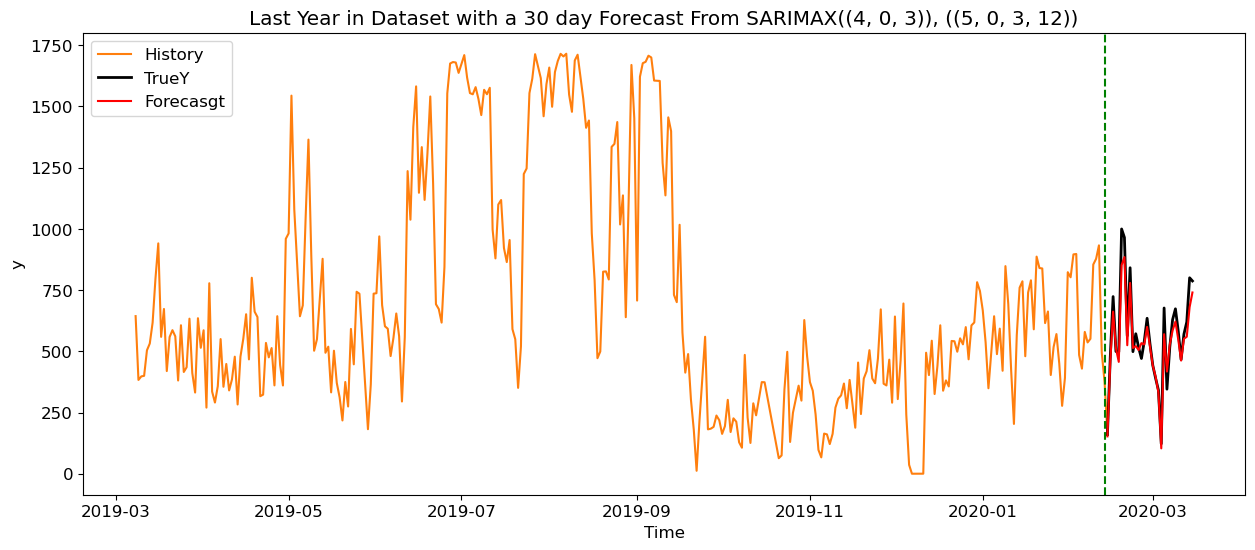

In [157]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(15, 6))


ax.plot(df.index[-365:-k+1], df['ActivePower'][-365:-k+1], color='tab:orange', label='History')

ax.plot(df.index[-k:], df['ActivePower'][-k:], color='black', label='TrueY', linewidth=2)
ax.plot(df.index[-k:], forecast, color='red', label='Forecasgt')
ax.axvline(x=df.index[-k-1:-k], c='green', linestyle='--')

ax.set_xlabel('Time')
ax.set_ylabel('y')
plt.title(f'Last Year in Dataset with a 30 day Forecast From SARIMAX({best_trend}), ({best_seasonality})')
plt.legend()

## Theta Model Attempt

In [158]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.forecasting.theta import ThetaModel

theta_model = ThetaModel(y, period=k)
theta_fit = theta_model.fit()

forecasts = theta_fit.forecast(steps=k)
print(f'Theta RMSE: {np.sum(mean_squared_error(np.array(forecasts), testY)) / testY.shape[0]}')

Theta RMSE: 1859.7053847428065


Terrible.

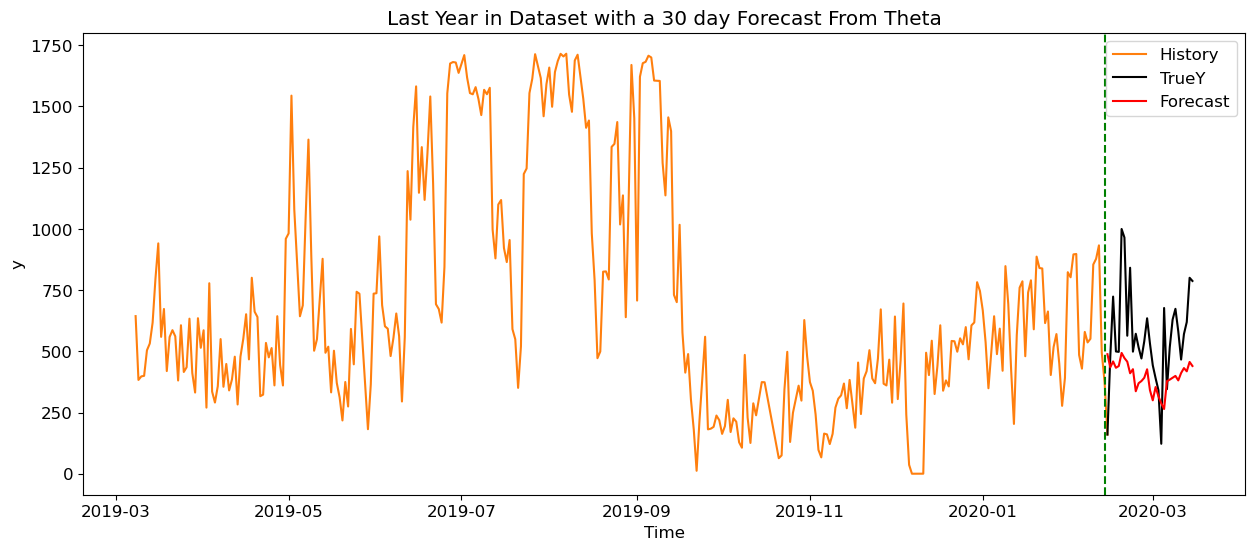

In [159]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(df.index[-365:-k+1], df['ActivePower'][-365:-k+1], color='tab:orange', label='History')
#ax.plot(df.index[-365:-k+1], forecast['yhat'][-365:-k+1], color='b', label='Prediction')

ax.plot(df.index[-k:], df['ActivePower'][-k:], color='black', label='TrueY')
ax.plot(df.index[-k:], forecasts, color='red', label='Forecast')
ax.axvline(x=df.index[-k-1:-k], c='green', linestyle='--')

ax.set_xlabel('Time')
ax.set_ylabel('y')
plt.title('Last Year in Dataset with a 30 day Forecast From Theta')
plt.legend()

## Prophet Model Attempt

In [160]:
exog = ['Temps', 'WindSpeed', 'RotorRPM'] # Exogenous Variables to Include
import prophet
# create df 
dataTrain = pd.DataFrame()
dataTrain['y'] = y
dataTrain['ds'] = df.index[:-k]
for og in exog:
    dataTrain[og] = X[og]
# make model
m = prophet.Prophet()
for og in exog:
    m.add_regressor(og)
m.fit(dataTrain)
# make df for predictions
future = m.make_future_dataframe(periods=k)
for og in exog:
    future[og] = df[og].values
# make predictions
forecast = m.predict(future)
print(f'Prophet RMSE:', (np.sum(mean_squared_error(forecast['yhat'][-k:], testY)) / testY.shape[0]))

19:16:40 - cmdstanpy - INFO - Chain [1] start processing
19:16:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE: 113.15639448329252


Prophet Results Forecasting 30 Days:
 - ['Temps'], RMSE: 1389.16
 - ['Temps', 'WindSpeed'], RMSE: 133.88
 - ['Temps', 'RotorRPM'], RMSE: 1379.29
 - ['Temps', 'WindSpeed', 'RotorRPM'], RMSE: 103.88
 - ['WindSpeed', 'RotorRPM'], RMSE: 110.19

Looks good!


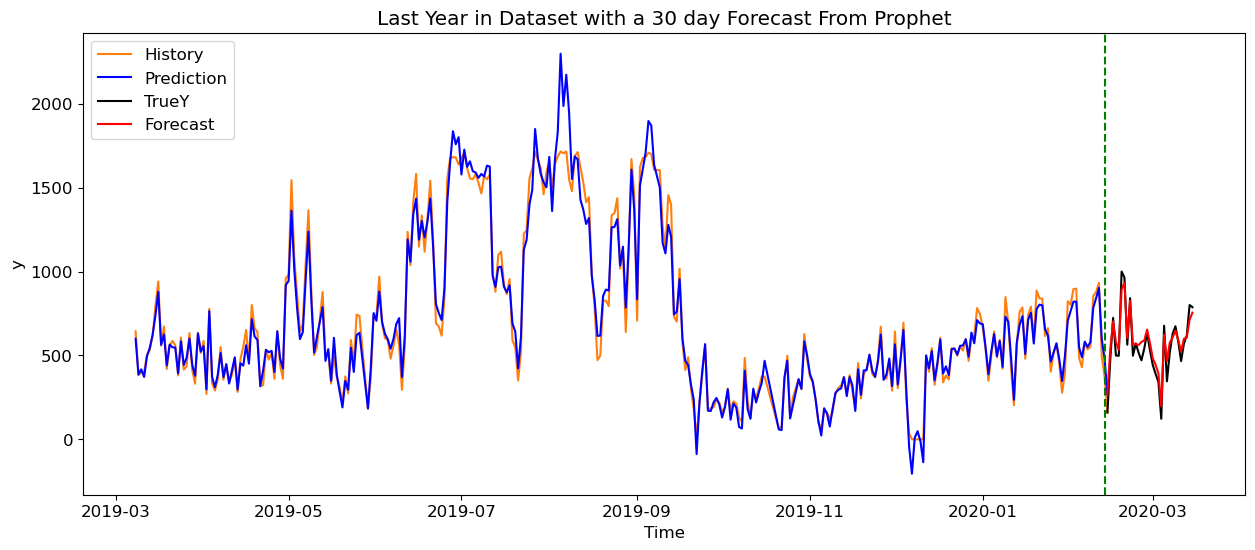

In [161]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(df.index[-365:-k+1], df['ActivePower'][-365:-k+1], color='tab:orange', label='History')
ax.plot(df.index[-365:-k+1], forecast['yhat'][-365:-k+1], color='b', label='Prediction')

ax.plot(df.index[-k:], df['ActivePower'][-k:], color='black', label='TrueY')
ax.plot(df.index[-k:], forecast['yhat'][-k:], color='red', label='Forecast')
ax.axvline(x=df.index[-k-1:-k], c='green', linestyle='--')

ax.set_xlabel('Time')
ax.set_ylabel('y')
plt.title('Last Year in Dataset with a 30 day Forecast From Prophet')
plt.legend()